# Question 2: LSTM + CAE video frame prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

Loading trained model form disk
Make transform func to preprocess dataset

In [3]:
# CAE reduced code dim = 16 in this case

from CAE import Encoder, Decoder
from torchvision.transforms import Lambda, Compose

encoder_path = './encoder.pt'
decoder_path = './decoder.pt'

encoder = Encoder(code_dim=16)
encoder.load_state_dict(torch.load(encoder_path));
decoder = Decoder(code_dim=16)
decoder.load_state_dict(torch.load(decoder_path));

transform = Compose([
    Lambda(lambda x: x / 255.),
    Lambda(lambda x: encoder(x)),
])

Construct Dataset

In [4]:
from lstm import FrameSeq

train_data = FrameSeq(split='train', transform=transform)
test_data = FrameSeq(split='test', transform=transform)

In [5]:
print(train_data.before.shape)
print(train_data.after.shape)

torch.Size([360, 4, 3, 128, 128])
torch.Size([360, 4, 3, 128, 128])


Build Dataloader

In [6]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [7]:
sample = next(iter(train_loader))

Build LSTM Model for training

In [8]:
from lstm import LSTMModel

lstm = LSTMModel()

Train the model

In [9]:
print(train_loader.__len__())
print(test_loader.__len__())

23
6


In [10]:
from lstm import LSTMModel, FF
model = LSTMModel()
# model = FF()
lr = 0.01
wd=1e-3
epoch = 10

optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=wd
)
criterion = torch.nn.MSELoss()

def train_epoch(model, optimizer, criterion, loader):
    model.train()
    train_loss = []
    for X, T in loader:
        pred = model(X)
        # print(X.mean().detach(), pred.mean().detach(), T.mean().detach())
        # print(X.max().detach(), pred.max().detach(), T.max().detach())
        # print(X.min().detach(), pred.min().detach(), T.min().detach())
        # print()
        optimizer.zero_grad()
        # print('***', pred.shape, T.shape)
        # print(pred.dtype, T.dtype)
        loss = criterion(pred, T)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach())
        # print('train_loss', train_loss)
    return np.mean(train_loss)

def test_epoch(model, criterion, loader):
    model.eval()
    test_loss = []
    with torch.no_grad():
        for X, T in loader:
            pred = model(X)
            loss = criterion(pred, T)
            test_loss.append(loss)
            # print('testlost', test_loss)
    return np.mean(test_loss)

def train(
    model, optimizer, criterion, train_loader,
    test_loader, epoch):
    for i in range(epoch):
        train_loss = train_epoch(
            model, optimizer, criterion, train_loader
        )
        test_loss = test_epoch(
            model, criterion, test_loader
        )
        print(
            f'''EPOCH {i + 1}/{epoch} \t train loss: {train_loss}\t test loss: {test_loss}'''
        )

train(model, optimizer, criterion, train_loader, test_loader, epoch)

EPOCH 1/10 	 train loss: 2092.306640625	 test loss: 2417.160400390625
EPOCH 2/10 	 train loss: 1699.5667724609375	 test loss: 2334.718505859375
EPOCH 3/10 	 train loss: 1349.1669921875	 test loss: 1670.7020263671875
EPOCH 4/10 	 train loss: 1156.5113525390625	 test loss: 1473.3509521484375
EPOCH 5/10 	 train loss: 1014.0416870117188	 test loss: 1513.3089599609375
EPOCH 6/10 	 train loss: 946.7994384765625	 test loss: 1428.9256591796875
EPOCH 7/10 	 train loss: 908.5946044921875	 test loss: 1437.6201171875
EPOCH 8/10 	 train loss: 869.1699829101562	 test loss: 1664.0745849609375
EPOCH 9/10 	 train loss: 862.1868896484375	 test loss: 1693.5538330078125
EPOCH 10/10 	 train loss: 818.7551879882812	 test loss: 1428.5108642578125


data visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


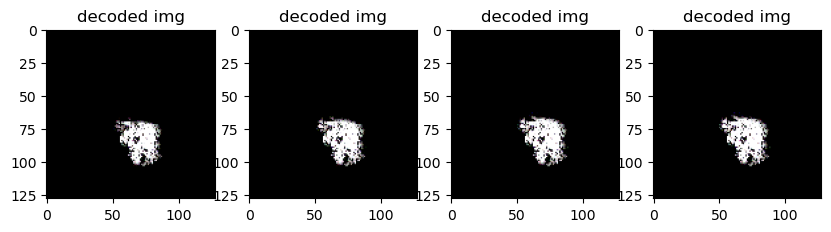

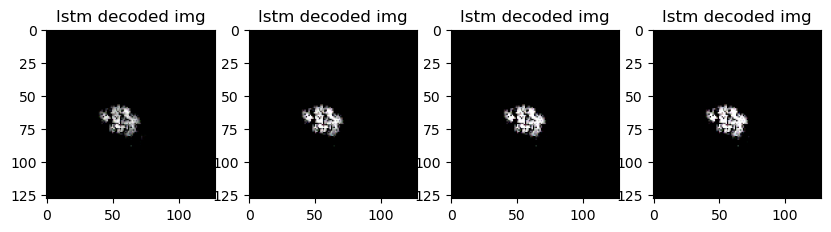

In [21]:
def show_seq(seq, title):
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))
    for i in range(4):
        axs[i].imshow(seq[i].permute(1, 2, 0));
        axs[i].set_title(title)

def visualize(model, loader, idx):
    with torch.no_grad():
        for X, T in loader:
            # print('in loop', T.shape)
            bs = X.shape[0] # batch size
            lat_pred = model(X) # predicted latent space representation
            # print('lat_pred dim', lat_pred.shape)
            pred_input = lat_pred.reshape(-1, 16) 
            targ_input = T.reshape(-1, 16)
            # print('input shape', pred_input.shape, targ_input.shape) # reshape for decoder input
            pred_out = decoder(pred_input) # out put from decoder
            targ_out = decoder(targ_input)
            # print('output shape', pred_out.shape, targ_out.shape)
            pred_res = pred_out.reshape(bs, 4, 3, 128, 128)
            targ_out = targ_out.reshape(bs, 4, 3, 128, 128)
            # print('res shape', pred_res.shape, targ_out.shape)
            show_seq(targ_out[idx], 'decoded img')
            show_seq(pred_res[idx], 'lstm decoded img')
            break

visualize(model, test_loader, 10)

model evaluation

In [12]:
def RMSELoss(pred, target):
    return torch.sqrt(torch.square(pred - target)).mean().detach().numpy()

def evaluate(model, loader, criterion):
    model.eval()
    loss = []
    with torch.no_grad():
        for X, T in loader:
            bs = X.shape[0] # batch size
            lat_pred = model(X) # predicted latent space representation
            # print('lat_pred dim', lat_pred.shape)
            pred_input = lat_pred.reshape(-1, 16) 
            targ_input = T.reshape(-1, 16)
            # print('input shape', pred_input.shape, targ_input.shape) # reshape for decoder input
            pred_out = decoder(pred_input) # out put from decoder
            targ_out = decoder(targ_input)
            # print('output shape', pred_out.shape, targ_out.shape)
            pred_res = pred_out.reshape(-1, 3, 128, 128)
            targ_out = targ_out.reshape(-1, 3, 128, 128)
            cur_loss = criterion(pred_res, targ_out)
            loss.append(cur_loss)
    return np.mean(loss)


In [13]:
print('MSELoss: ', evaluate(model, test_loader, torch.nn.MSELoss()))

MSELoss:  0.016622486


In [14]:
print('RMSELoss: ', evaluate(model, test_loader, RMSELoss))

RMSELoss:  0.018533567


In [15]:
from skimage.metrics import structural_similarity

def ssim(x, y):
    x = x.detach().numpy()
    y = y.detach().numpy()
    return np.mean([structural_similarity(x[i], y[i], channel_axis=0) for i in range(len(x))])

print('SSIM: ', evaluate(model, test_loader, ssim))

SSIM:  0.9317786
